# Adaptive Mixtures of Local Experts

This notebook contains a simple but flexible pytorch implementation of *[Adaptive Mixture of Local Experts](https://direct.mit.edu/neco/article-abstract/3/1/79/5560/Adaptive-Mixtures-of-Local-Experts?redirectedFrom=fulltext), Neural Computation (1991) 3 (1): 79–87.* A free but poor quality PDF of the paper can be found [here](https://www.cs.toronto.edu/~hinton/absps/jjnh91.pdf).

Here we apply mixtures of experts (MoE) in learning an unknown analytic function $f^*: \mathbb{R} \to \mathbb{R}$. We demonstrate that while a low capacity multilayer perceptron (MLP) fits the target function poorly, a MoE ensemble using the same MLP archtecture for the leaf model can fit much better.

## First import the usual suspects

In [1]:
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd
import seaborn as sns
import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader, TensorDataset

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Construct and plot a mystery target function

<Axes: >

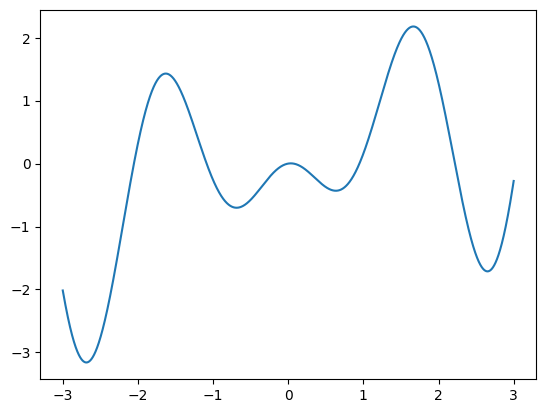

In [2]:
def target_function(x):
    return - 0.01*x**4 + .01*x**3 + .1*x**2 + .2*x**1 - 1*x*np.sin(3*x)

x = np.linspace(-3, 3, 100001)
y = target_function(x)
sns.lineplot(x=x, y=y)

## Partition the data into training and test sets

In [3]:
X = x.reshape(-1, 1)
y = y.reshape(-1, 1)
perm = npr.permutation(X.shape[0])

n_train = 10000
X_train = Tensor(X[perm[:n_train]])
y_train = Tensor(y[perm[:n_train]])
data_train = TensorDataset(X_train, y_train)

X_test = Tensor(X[perm[n_train:]])
y_test = Tensor(y[perm[n_train:]])
data_test = TensorDataset(X_test, y_test)


## Define a vanilla MLP class

The MLP model class serves as a baseline, and is used for both the expert and gating networks in the adaptive mixture of local experts model.

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, hidden_layers=1, hidden_dim=16):
        super().__init__()
        if hidden_layers == 0:
            self.net = self.net = nn.Linear(1, 1)
        else:
            layers = [
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
            ]
            for _ in range(hidden_layers):
                layers.extend([
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.ReLU(),
                ])
            layers.append(nn.Linear(hidden_dim, output_dim))
            self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)


## Define the mixture of experts model class

The MoE model class is initialized with a gating network and a list of expert networks.

In training, the gating network learns to delegate examples to the best predicting experts, and the best predicting experts adapt in order to fit their portions of the input space even better.

In [5]:
class MoE(nn.Module):
    def __init__(self,
                 gating_net : nn.Module,
                 experts : list[nn.Module]):
        super().__init__()
        self.gating_net = gating_net
        self.experts = self.linears = nn.ModuleList(experts)

    def forward(self, x: Tensor, predict_rule: str = "argmax") -> Union[Tensor, dict[str, Tensor]]:
        """
        In evaluation mode, this function returns a torch Tensor of
        predicted $\hat{y}$ values.

        In training mode, this function returns a dictionary with fields
            - expert_probs: a tensor of the expert responsibility weights
            - expert_yhats: a tensor of the expert $\hat{y}$ values

        :param x: input tensor
        :param predict_rule: one of {"argmax", "mean"}. If "argmax", then
            the prediction will be generated by the expert deemed to be the
            best by the gating network. If "mean", then the prediction will
            be a weighted average of the experts' predictions where the
            weighting is chosen by the gating network.
        """
        expert_probs = self.gating_net(x)
        expert_yhats = torch.concat([expert(x) for expert in self.experts], dim=1)

        if self.training:
            return {
                "expert_probs" : expert_probs,
                "expert_yhats" : expert_yhats,
            }

        # otherwise we are in predict mode
        if predict_rule == "argmax":
            ii = torch.arange(len(expert_probs))
            jj = expert_probs.argmax(dim=1)
            yhats = expert_yhats[ii,jj]

        elif predict_rule == "mean":
            yhats = (expert_probs * expert_yhats).sum(dim=1)

        else:
            raise ValueError(f"unknown predict rule '{predict_rule}")

        return yhats.view(-1, 1)


## Define the mixture of experts loss

The MoE loss function is a function of three arguments:
1. true target, $y$
1. expert responsibility probabilities, $\{p_m\}_{m=1}^{M}$, where $M$ is the number of experts and $p_m \triangleq \Pr(\,\text{PickedExpert}=m \mid X=x\,).$
1. predictions made by the experts $\{\hat{y}_m\}_{m=1}^M$, $$\hat{y}_m \triangleq \text{E}\left[\, Y \mid \text{PickedExpert}=m \text{ and }X=x\,\right].$$

MoE loss is the negative log-loss of the target $y$ given the input, $x$, according to the ensemble:
$$
\text{loss}_\textit{moe}(\,y, \{p_m\}, \{\hat{y}_m\}\,)
= -\log\left(\sum_{m} \,p_m \cdot \Pr(y \mid \hat{y}_m) \right).
$$
where $\Pr(y \mid \hat{y})$ depends on the assumed likelihood model.

For example $\Pr(y \mid \hat{y}) \propto \exp(-|y - \hat{y}|^2/2\sigma^2)$ if we assume that $Y \sim \mathcal{N}(\hat{y}, \sigma^2)$. Alternatively, $\Pr(y \mid \hat{y}) = (\hat{y})^y + (1 - \hat{y})^{(1-y)}$ if we assume $Y \sim \text{Ber}(\hat{y})$.

In [6]:
class MOELoss(nn.Module):
    def __init__(self, expert_log_loss_fn=None):
        super().__init__()
        self.expert_log_loss_fn = expert_log_loss_fn
    
    def forward(self, preds: dict[str, Tensor], y: Tensor) -> Tensor:
        loss_fn = self.expert_log_loss_fn
        p_E_given_X = preds['expert_probs']
        yhats = preds['expert_yhats']
        log_losses = []
        for m in range(yhats.shape[1]):
            yhat_m = yhats[:,m].view(-1,1)
            log_losses.append(loss_fn(yhat_m, y))
        log_losses = torch.concat(log_losses, dim=1)
        p_Y_given_E = torch.exp(-log_losses)
        p_Y_given_X = (p_Y_given_E * p_E_given_X).sum(dim=1)
        loss = -torch.log(p_Y_given_X).mean()
        return loss

## Define train and predict routines

In [7]:
def train(dataset: Dataset,
          model: nn.Module,
          epochs: int = 10,
          loss_fn: nn.Module = None,
          optimizer: torch.optim.Optimizer = None) -> None:
    if optimizer is None:
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-6)
    if loss_fn is None:
        loss_fn = nn.MSELoss()
    dataloader = DataLoader(dataset, batch_size=100, shuffle=True)
    size = len(dataloader.dataset)
    model.train()
    
    for epoch in range(epochs):
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)
            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if batch == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f} [{epoch=}] [{current:>5d}/{size:>5d}]")        
    return

def predict(dataset, model: nn.Module) -> tuple[Tensor, Tensor]:
    dataloader = DataLoader(dataset, batch_size=100)
    model.eval()
    ys = []
    yhats = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            ys.append(y)
            yhats.append(model(X))
    return torch.concat(ys), torch.concat(yhats)


## Test a baseline MLP with one hidden layer and 8 hidden units

loss: 2.780946 [epoch=0] [  100/10000]
loss: 0.632907 [epoch=1] [  100/10000]
loss: 0.241800 [epoch=2] [  100/10000]
loss: 0.204565 [epoch=3] [  100/10000]
loss: 0.141459 [epoch=4] [  100/10000]
loss: 0.093903 [epoch=5] [  100/10000]
loss: 0.110608 [epoch=6] [  100/10000]
loss: 0.100720 [epoch=7] [  100/10000]
loss: 0.071095 [epoch=8] [  100/10000]
loss: 0.053524 [epoch=9] [  100/10000]
loss: 0.039122 [epoch=10] [  100/10000]
loss: 0.021535 [epoch=11] [  100/10000]
loss: 0.029124 [epoch=12] [  100/10000]
loss: 0.030988 [epoch=13] [  100/10000]
loss: 0.020759 [epoch=14] [  100/10000]
loss: 0.015613 [epoch=15] [  100/10000]
loss: 0.022345 [epoch=16] [  100/10000]
loss: 0.036145 [epoch=17] [  100/10000]
loss: 0.021272 [epoch=18] [  100/10000]
loss: 0.024981 [epoch=19] [  100/10000]
loss: 0.026346 [epoch=20] [  100/10000]
loss: 0.022370 [epoch=21] [  100/10000]
loss: 0.034108 [epoch=22] [  100/10000]
loss: 0.027529 [epoch=23] [  100/10000]
loss: 0.025808 [epoch=24] [  100/10000]
loss: 0.01

<Axes: >

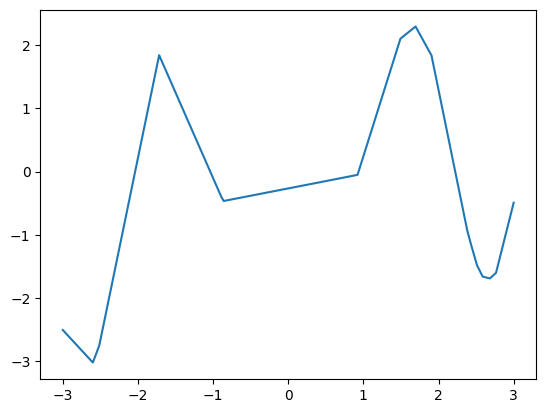

In [8]:
mlp = MLP(hidden_dim=8, hidden_layers=1)
train(dataset=data_train, model=mlp, epochs=30)
ys, yhats = predict(data_test, mlp) 
sns.lineplot(x=X_test.numpy().squeeze(), y=yhats.numpy().squeeze())

## Now test an MoE that uses the same MLP for leaf model and gating networks

Here we set the number of experts in the ensemble to 16.

In [9]:
num_experts = 16

gating_net = nn.Sequential(
    MLP(output_dim=num_experts, hidden_dim=8, hidden_layers=1),
    nn.Softmax(dim=1)
)

experts = [
    MLP(hidden_dim=8, hidden_layers=1) for _ in range(num_experts)
]

moe = MoE(gating_net, experts)

train(
    dataset=data_train,
    model=moe,
    epochs=30,
    loss_fn=MOELoss(expert_log_loss_fn=nn.MSELoss(reduction='none'))
)

loss: 1.446329 [epoch=0] [  100/10000]
loss: 0.312311 [epoch=1] [  100/10000]
loss: 0.080859 [epoch=2] [  100/10000]
loss: 0.055485 [epoch=3] [  100/10000]
loss: 0.053707 [epoch=4] [  100/10000]
loss: 0.035884 [epoch=5] [  100/10000]
loss: 0.011370 [epoch=6] [  100/10000]
loss: 0.028396 [epoch=7] [  100/10000]
loss: 0.016651 [epoch=8] [  100/10000]
loss: 0.021706 [epoch=9] [  100/10000]
loss: 0.022376 [epoch=10] [  100/10000]
loss: 0.019319 [epoch=11] [  100/10000]
loss: 0.012657 [epoch=12] [  100/10000]
loss: 0.011067 [epoch=13] [  100/10000]
loss: 0.018833 [epoch=14] [  100/10000]
loss: 0.013807 [epoch=15] [  100/10000]
loss: 0.008507 [epoch=16] [  100/10000]
loss: 0.010132 [epoch=17] [  100/10000]
loss: 0.008873 [epoch=18] [  100/10000]
loss: 0.006943 [epoch=19] [  100/10000]
loss: 0.010982 [epoch=20] [  100/10000]
loss: 0.005665 [epoch=21] [  100/10000]
loss: 0.003447 [epoch=22] [  100/10000]
loss: 0.007607 [epoch=23] [  100/10000]
loss: 0.003679 [epoch=24] [  100/10000]
loss: 0.00

## The MoE fit is better than the single MLP

<Axes: >

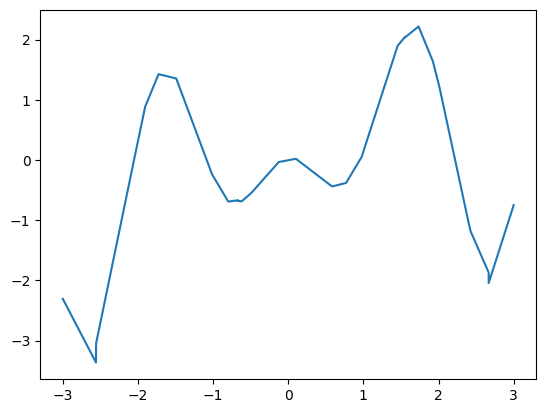

In [10]:
ys, yhats = predict(data_test, moe)
sns.lineplot(x=X_test.numpy().squeeze(), y=yhats.numpy().squeeze())

### Here's the target function again for comparison

<Axes: >

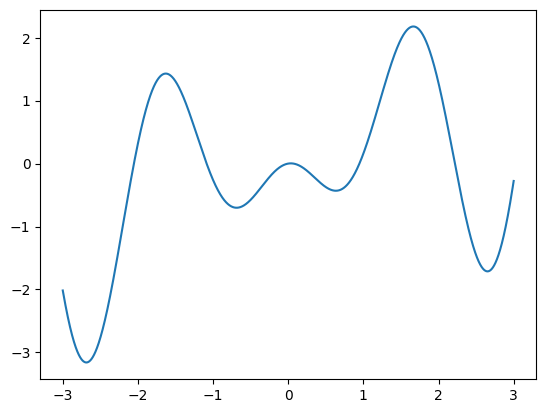

In [11]:
sns.lineplot(x=X_test.numpy().squeeze(), y=ys.squeeze())